In [2]:
import pandas as pd
import numpy as np
from copy import copy, deepcopy

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score

from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:
df_full = pd.read_csv('data3.csv', index_col=0)
# label_cols = [c for c in df_full.columns if 'genre_' in c]
label_cols = ['genre_' + g for g in ['black', 'death', 'doom', 'folk', 'heavy', 'power', 'progressive', 'thrash']]
df_full['genre_other'] = (df_full[label_cols].sum(axis=1) == 0).astype(int)
label_cols.append('genre_other')
feature_cols = [c for c in df_full.columns if 'genre_' not in c]
genres = [c.replace('genre_', '') for c in label_cols]
print('genres: ', genres)

genres:  ['black', 'death', 'doom', 'folk', 'heavy', 'power', 'progressive', 'thrash', 'other']


In [4]:
words = set()
for label_col in label_cols:
    corr = df_full[feature_cols].apply(lambda x: x.corr(df_full[label_col]))
#     corr = corr[corr.abs().argsort()][len(corr) // 2:].sort_values()
    corr_words = corr.index[corr.abs() > 3 * corr.abs().mean()]
    words.update(set(corr_words))
feature_cols_r = sorted(words)

In [5]:
len(feature_cols_r), len(feature_cols)

(11511, 35258)

In [6]:
class StackedModel:
    def __init__(self, base_models, final_model):
        self.base_models = base_models
        self.final_model = final_model

    @property
    def model_names(self):
        return [type(m).__name__ for m in self.base_models]

    def fit(self, X, y, n_splits=5, random_state=0):
        folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#         df_train_pred = pd.DataFrame(index=range(len(y)), columns=self.model_names)
        S = np.zeros((len(y), len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_idx, val_idx in folds.split(X, y):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                model.fit(X_train, y_train)
#                 y_fold_pred = model.predict(X_val)
#                 df_train_pred.iloc[val_idx, i] = model.predict(X_val)
                S[val_idx, i] = model.predict_proba(X_val)[:, 1]
#         S_train = df_train_pred.values
        S = S.mean(axis=1).reshape(-1, 1)
        self.final_model.fit(S, y)

    def predict(self, X):
#         df_test_pred = pd.DataFrame(index=range(X.shape[0]), columns=self.model_names)
#         for i, model in enumerate(self.base_models):
#             df_test_pred.iloc[:, i] = model.predict(X)
#         S = df_test_pred.values
        S = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            S[:, i] = model.predict_proba(X)[:, 1]
        S = S.mean(axis=1).reshape(-1, 1)
        y = self.final_model.predict(S)
        return y

    def predict_proba(self, X):
#         df_test_pred = pd.DataFrame(index=range(X.shape[0]), columns=self.model_names)
#         for i, model in enumerate(self.base_models):
#             df_test_pred.iloc[:, i] = model.predict(X)
        S = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            S[:, i] = model.predict_proba(X)[:, 1]
        S = S.mean(axis=1).reshape(-1, 1)
        y = self.final_model.predict_proba(S)
        return y

In [35]:
class BinaryRelevance:
    def __init__(self, estimator, features, labels, oversampler=None):
        self.estimator = estimator
        self.features = features
        self.labels = labels
        self.estimators_ = {}
        self.oversampler = oversampler

    def fit(self, df_train, **kwargs):
        X_train = df_train[self.features].values
        models = {}
        for label in self.labels:
            y_train = df_train[label].values
            if self.oversampler:
                X_train_resample, y_train_resample = self.oversampler.fit_resample(X_train, y_train)
            else:
                X_train_resample, y_train_resample = X_train, y_train
            model = deepcopy(self.estimator)
            model.fit(X_train_resample, y_train_resample, n_splits=5)
            models[label] = model
        self.estimators_ = models

    def predict(self, df_test):
        X_test = df_test[self.features].values
        df_true = pd.DataFrame(index=df_test.index, columns=self.labels)
        df_pred = pd.DataFrame(index=df_test.index, columns=self.labels)
        df_prob = pd.DataFrame(index=df_test.index, columns=self.labels)
        for label in self.labels:
            model = self.estimators_[label]
            y_test = df_test[label].values
            y_prob = model.predict_proba(X_test)
            df_true[label] = df_test[label]
            df_prob[label] = y_prob[:, 1]
        df_prob = df_prob.div(df_prob.sum(axis=1), axis=0)
        thresh = 1. / len(self.labels)
        for i, row in df_prob.iterrows():
            df_pred.loc[i] = (row >= thresh).astype(int)
        return df_pred, df_prob, df_true

In [8]:
best_params = {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

In [36]:
df_features = df_full[feature_cols_r]
df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
df_train, df_test = train_test_split(df_norm, test_size=0.2, random_state=0)
br = BinaryRelevance(
    StackedModel(
        base_models=[
            RandomForestClassifier(n_jobs=-1, random_state=0, **best_params),
#             LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=0)
#             GaussianNB()
        ],
        final_model=LogisticRegression(solver='lbfgs', random_state=0)
    ),
    feature_cols_r,
    label_cols
)
br.fit(df_train, oversampler=RandomOverSampler(random_state=0))
df_pred, df_prob, df_true = br.predict(df_test)
for label in label_cols:
    print("{}: {:.4f}".format(label.replace('genre_', ''), balanced_accuracy_score(df_true[label], df_pred[label])))

black: 0.7033
death: 0.5994
doom: 0.5689
folk: 0.5000
heavy: 0.8733
power: 0.8947
progressive: 0.5856
thrash: 0.7121
other: 0.5000


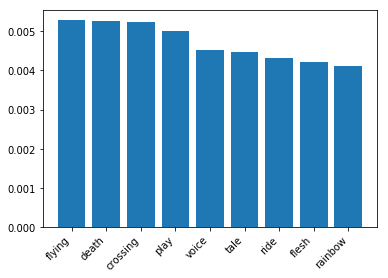

In [37]:
feature_importances = br.estimators_['genre_power'].base_models[0].feature_importances_
sort_idx = feature_importances.argsort()[:-10:-1]
plt.bar(np.array(feature_cols_r)[sort_idx], feature_importances[sort_idx])
plt.xticks(rotation=45, ha='right')
plt.show()

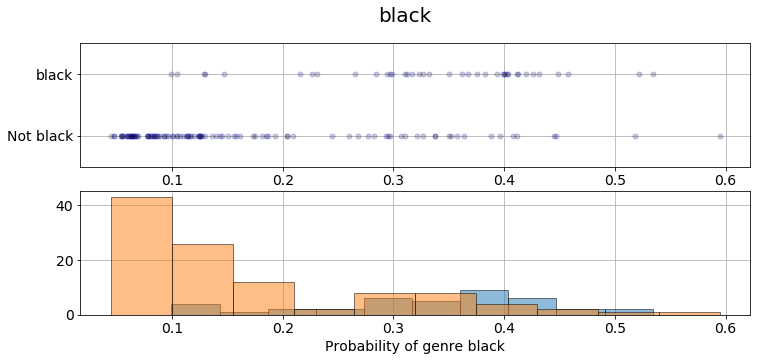

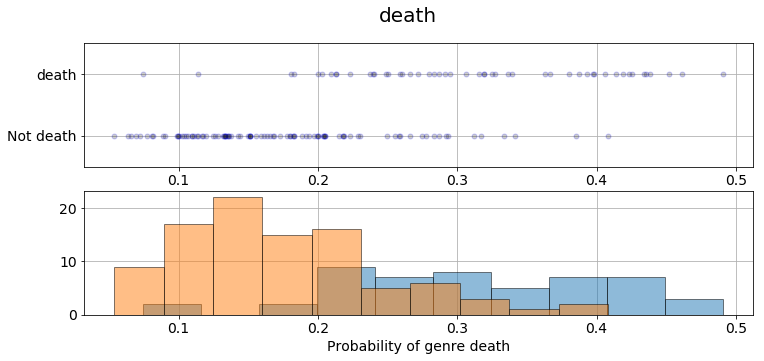

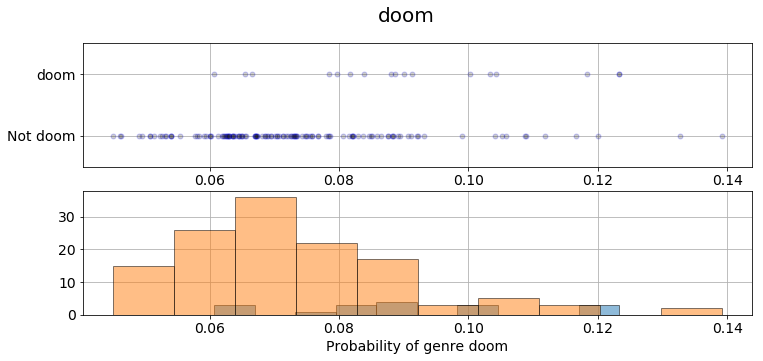

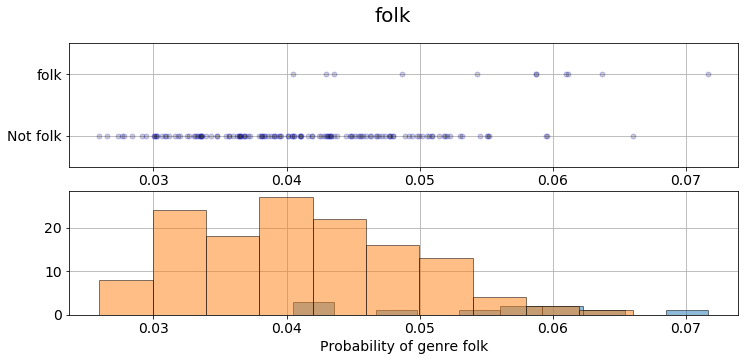

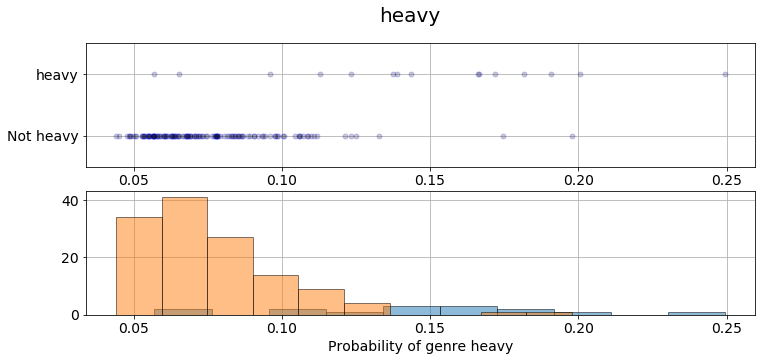

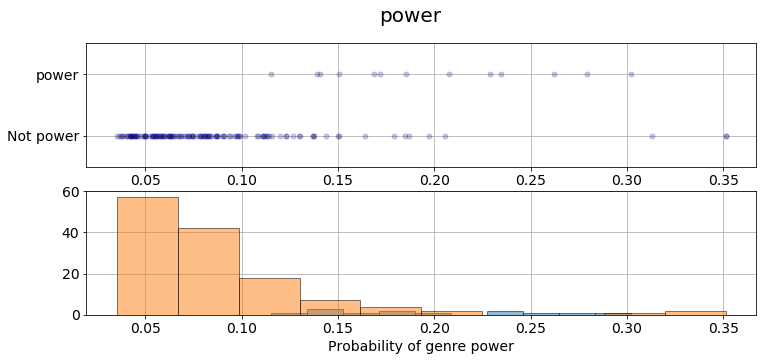

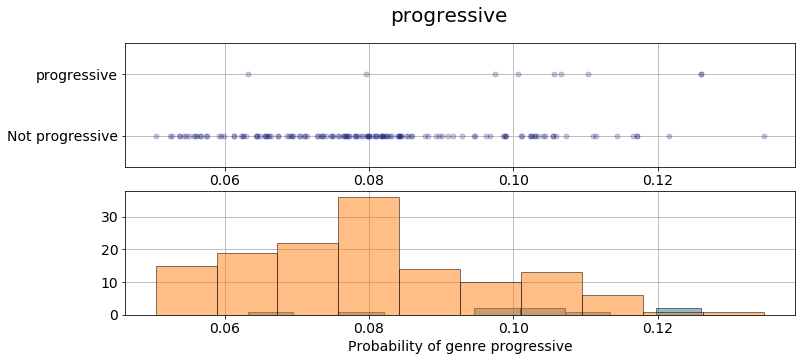

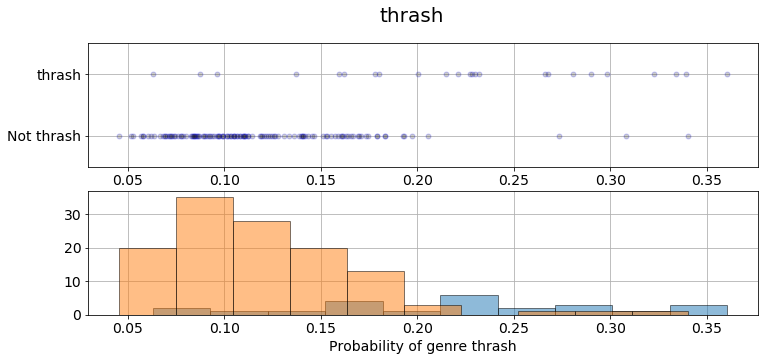

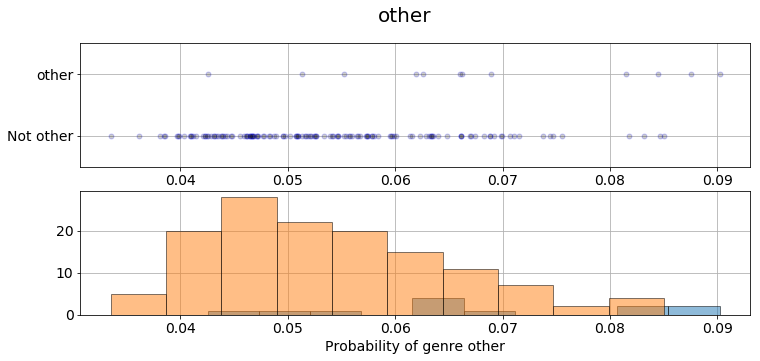

In [39]:
# bins = np.linspace(0, 1, 21)
# xticks = np.linspace(0, 1, 11)
for label in df_pred.columns:
    genre = label.replace('genre_', '')
    y_prob = df_prob[label]
    y_true = df_true[label]
    plt.figure(figsize=(12, 5))
    plt.suptitle(genre, fontsize=20)
    plt.subplot(2, 1, 1)
    plt.plot(y_prob, y_true, 'o', markersize=5, markerfacecolor='none', markeredgecolor='b', alpha=0.2)
#     plt.xlim(0, 1)
    plt.ylim(-0.5, 1.5)
    plt.tick_params(labelsize=14)
#     plt.xticks(xticks)
    plt.yticks([0, 1], ["Not " + genre, genre])
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.hist(y_prob[y_true == 1], bins=10, alpha=0.5, edgecolor='k')
    plt.hist(y_prob[y_true == 0], bins=10, alpha=0.5, edgecolor='k')
#     plt.xlim(0, 1)
    plt.tick_params(labelsize=14)
    plt.xlabel("Probability of genre " + genre, fontsize=14)
#     plt.xticks(xticks)
    plt.grid()
    plt.gca().set_axisbelow(True)
    plt.show()

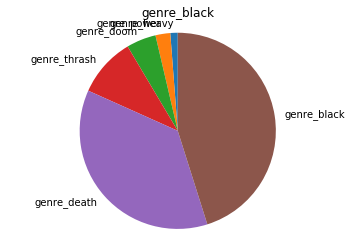

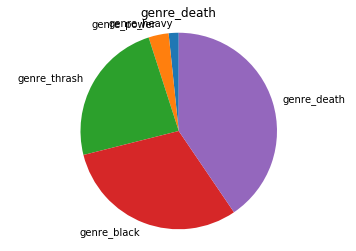

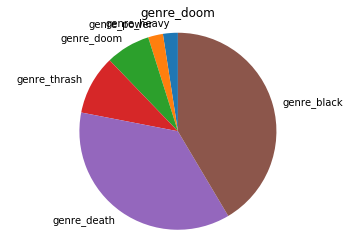

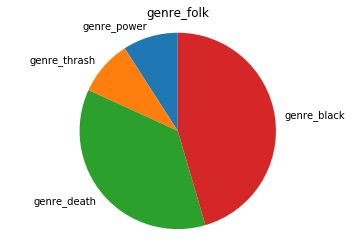

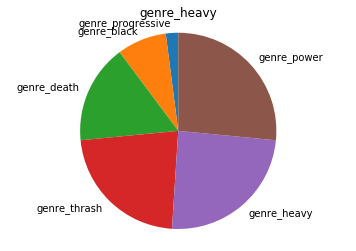

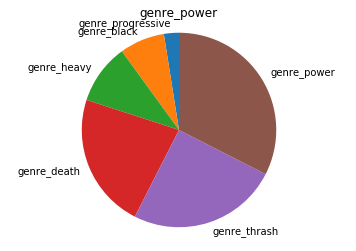

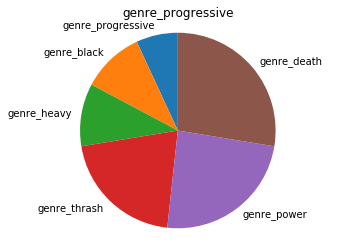

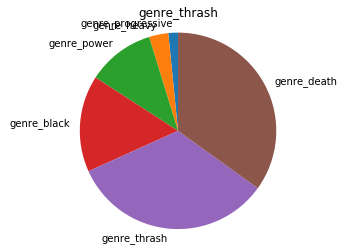

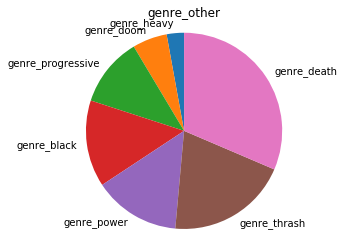

In [38]:
for label in label_cols:
    pie_data = df_pred[df_true[label].astype(bool)].sum(axis=0).sort_values()
    pie_data = pie_data[pie_data > 0]
    plt.pie(pie_data.values, labels=pie_data.index, startangle=90)
    plt.axis('equal')
    plt.title(label)
    plt.show()

In [53]:
df_pred

,genre_black,genre_death,genre_doom,genre_folk,genre_heavy,genre_power,genre_progressive,genre_thrash,genre_other
sepultura,0,1,0,0,0,0,0,1,0
overkill,0,1,0,0,1,1,0,1,0
skyforger,1,1,0,0,0,0,0,0,0
nasum,0,1,0,0,0,0,0,1,0
ophthalamia,1,1,0,0,0,0,0,0,0
entombed,0,1,0,0,1,0,0,1,0
interment,1,1,0,0,0,0,0,0,0
andromeda,0,1,0,0,1,1,0,1,0
allegiance,0,1,0,0,0,0,0,1,0
acrostichon,1,1,0,0,0,0,0,1,0
